In [1]:
import warnings
warnings.simplefilter('ignore')

import os
import gc

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
from tqdm.auto import tqdm

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_log_error

import lightgbm as lgb

from matplotlib.pyplot import plot, show

In [2]:
# 玩家角色表

roles = pd.read_csv('datasets/role_id.csv')

# 共七天, roles 表填充完整
dfs = []
for i in range(2, 9):
    tmp = roles.copy()
    tmp['day'] = i
    dfs.append(tmp)
data = pd.concat(dfs).reset_index(drop=True)
data

,role_id,create_time,day
0,28b9114a5784b724997257c3,1593268403,2
1,51d43143f0e8c695792ee1d4,1613439868,2
2,52f2bb2665cdb5d81dd245ba,1612927043,2
3,1f3c325b343a3f56b898265e,1614044315,2
4,76d3a7bd0a8ed2b011a99aae,1614056679,2
...,...,...,...
75455,f0f80e12dfa091b5fba71de0,1609603813,8
75456,1cae51d9bd791f6337d1e612,1615136565,8
75457,e6170ea5237741839701d6e6,1615202540,8
75458,42713418593ef32b3f65cc03,1584760818,8


In [3]:
# 货币消耗表
consume = pd.read_csv('datasets/role_consume_op.csv')
consume['dt'] = pd.to_datetime(consume['dt'])
consume['day'] = consume['dt'].dt.day

# 货币消耗按天合并
# TODO: mtime 可以做时差衍生特征, 其他表也是一样的
for i in range(1, 5):
    for m in ['count', 'sum']:
        tmp = consume.groupby(['role_id', 'day'])[f'use_t{i}'].agg(m).to_frame(name=f'use_t{i}_day_{m}').reset_index()
        data = data.merge(tmp, on=['role_id', 'day'], how='left')


In [4]:
# 升级表

evolve = pd.read_csv('datasets/role_evolve_op.csv')
evolve['dt'] = pd.to_datetime(evolve['dt'])
evolve['day'] = evolve['dt'].dt.day
evolve['n_level_up'] = evolve['new_lv'] - evolve['old_lv']
evolve = evolve.rename(columns={'num': 'lv_consume_item_num'})

for col in ['type', 'item_id']:
    for m in ['count', 'nunique']:
        tmp = evolve.groupby(['role_id', 'day'])[col].agg(m).to_frame(name=f'{col}_day_{m}').reset_index()
        data = data.merge(tmp, on=['role_id', 'day'], how='left')
for col in ['lv_consume_item_num', 'n_level_up']:
    for m in ['sum', 'mean']:
        tmp = evolve.groupby(['role_id', 'day'])[col].agg(m).to_frame(name=f'{col}_day_{m}').reset_index()
        data = data.merge(tmp, on=['role_id', 'day'], how='left')

In [5]:
# 副本表
# TODO: 这个表信息比较多, 可以多挖掘

fb = pd.read_csv('datasets/role_fb_op.csv')
fb['dt'] = pd.to_datetime(fb['dt'])
fb['day'] = fb['dt'].dt.day
fb['fb_used_time'] = fb['finish_time'] - fb['start_time']

for col in ['fb_id', 'fb_type']:
    for m in ['count', 'nunique']:
        tmp = fb.groupby(['role_id', 'day'])[col].agg(m).to_frame(name=f'{col}_day_{m}').reset_index()
        data = data.merge(tmp, on=['role_id', 'day'], how='left')
for col in ['fb_used_time', 'exp']:
    for m in ['sum', 'mean']:
        tmp = fb.groupby(['role_id', 'day'])[col].agg(m).to_frame(name=f'{col}_day_{m}').reset_index()
        data = data.merge(tmp, on=['role_id', 'day'], how='left')
        
tmp = fb.groupby(['role_id', 'day'])['fb_result'].value_counts().reset_index(name='fb_result_count')        
for i in [0, 1, 2]:
    tt = tmp[tmp['fb_result'] == i]
    tt.columns = list(tt.columns[:-1]) + ['fb_result%d_count'%i]
    data = data.merge(tt[['role_id', 'day', 'fb_result%d_count'%i]], on=['role_id', 'day'], how='left')

In [6]:
# 任务系统表

mission = pd.read_csv('datasets/role_mission_op.csv')
mission['dt'] = pd.to_datetime(mission['dt'])
mission['day'] = mission['dt'].dt.day

for col in ['mission_id', 'mission_type']:
    for m in ['count', 'nunique']:
        tmp = mission.groupby(['role_id', 'day'])[col].agg(m).to_frame(name=f'{col}_day_{m}').reset_index()
        data = data.merge(tmp, on=['role_id', 'day'], how='left')

In [7]:
# 玩家离线表
# TODO: 可以做很多时间、坐标方面的特征

offline = pd.read_csv('datasets/role_offline_op.csv')
offline['dt'] = pd.to_datetime(mission['dt'])
offline['day'] = offline['dt'].dt.day
offline['online_durations'] = offline['offline'] - offline['online']

for col in ['reason', 'map_id']:
    for m in ['count', 'nunique']:
        tmp = offline.groupby(['role_id', 'day'])[col].agg(m).to_frame(name=f'{col}_day_{m}').reset_index()
        data = data.merge(tmp, on=['role_id', 'day'], how='left')
        
for col in ['online_durations']:
    for m in ['mean', 'sum']:
        tmp = offline.groupby(['role_id', 'day'])[col].agg(m).to_frame(name=f'{col}_day_{m}').reset_index()
        data = data.merge(tmp, on=['role_id', 'day'], how='left')

In [8]:
# 付费表

pay = pd.read_csv('datasets/role_pay.csv')
pay['dt'] = pd.to_datetime(pay['dt'])
pay['day'] = pay['dt'].dt.day
tmp = pay.groupby(['role_id', 'day'])['pay'].agg('sum').to_frame(name='pay_sum_day').reset_index()
data = data.merge(tmp, on=['role_id', 'day'], how='left')
data['pay_sum_day'].fillna(0., inplace=True)

In [9]:
# 验证集设置
# 现在我们可以把问题转为用前n天的行为来预测第n+1天的付费

# 训练集 day 2,3,4,5,6 -> 标签 day 7 pay_sum
df_train = pd.DataFrame({'role_id': data.role_id.unique().tolist()})
for i, d in enumerate(range(2, 7)):
    tmp = data[data.day == d].copy().reset_index(drop=True)
    tmp.drop(['create_time', 'day'], axis=1, inplace=True)
    tmp.columns = ['role_id'] + [f'{c}_day{i}' for c in tmp.columns[1:]]
    df_train = df_train.merge(tmp, on='role_id')

# 验证集 day 3,4,5,6,7 -> 标签 day 8 pay_sum
df_valid = pd.DataFrame({'role_id': data.role_id.unique().tolist()})
for i, d in enumerate(range(3, 8)):
    tmp = data[data.day == d].copy().reset_index(drop=True)
    tmp.drop(['create_time', 'day'], axis=1, inplace=True)
    tmp.columns = ['role_id'] + [f'{c}_day{i}' for c in tmp.columns[1:]]
    df_valid = df_valid.merge(tmp, on='role_id')
    
# 测试集 day 4,5,6,7,8
df_test = pd.DataFrame({'role_id': data.role_id.unique().tolist()})
for i, d in enumerate(range(4, 9)):
    tmp = data[data.day == d].copy().reset_index(drop=True)
    tmp.drop(['create_time', 'day'], axis=1, inplace=True)
    tmp.columns = ['role_id'] + [f'{c}_day{i}' for c in tmp.columns[1:]]
    df_test = df_test.merge(tmp, on='role_id')

    
#标签构造

# 训练集 day == 7 pay_sum
# 验证集 day == 8 pay_sum

day7_pay = pay[pay.day == 7].copy().reset_index(drop=True)
tmp = day7_pay.groupby('role_id')['pay'].agg('sum').to_frame(name='pay').reset_index()
df_train = df_train.merge(tmp, on='role_id', how='left')
df_train['pay'].fillna(0., inplace=True)


day8_pay = pay[pay.day == 8].copy().reset_index(drop=True)
tmp = day8_pay.groupby('role_id')['pay'].agg('sum').to_frame(name='pay').reset_index()
df_valid = df_valid.merge(tmp, on='role_id', how='left')
df_valid['pay'].fillna(0., inplace=True)

In [10]:
df = pd.concat([df_train, df_valid, df_test]).reset_index(drop=True)

df['pay_log'] = np.log1p(df['pay'])

In [11]:
df_train = df[:len(df_train)].reset_index(drop=True)
df_valid = df[len(df_train):len(df_train)+len(df_valid)].reset_index(drop=True)
df_test = df[-len(df_test):].reset_index(drop=True)

In [24]:
# params = {
#     'objective': 'regression',
#     'metric': {'rmse'},
#     'boosting_type' : 'gbdt',
#     'learning_rate': 0.05,
#     'max_depth' : 7,
#     'num_leaves' : 31,
#     'feature_fraction' : 0.8,
#     'subsample' : 0.8,
#     'seed' : 114,
#     'num_iterations' : 3000,
#     'nthread' : -1,
#     'verbose' : -1
# }
params = {
    'objective': 'regression',
    'metric': {'rmse'},
    'boosting_type' : 'gbdt',
    'learning_rate': 0.05,
    'max_depth' : 8,
    'num_leaves' : 40,
    'feature_fraction' : 0.8,
    'subsample' : 0.8,
    'min_child_samples': 25,
    'seed' : 114,
    'num_iterations' : 3000,
    'nthread' : -1,
    'verbose' : -1,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1
}
features = [col for col in df_train.columns if col not in ['role_id', 'pay', 'pay_log']]
len(features)

190

Training until validation scores don't improve for 100 rounds
[50]	training's rmse: 0.344312	valid_1's rmse: 0.492025
[100]	training's rmse: 0.313029	valid_1's rmse: 0.495362
[150]	training's rmse: 0.287231	valid_1's rmse: 0.497855
Early stopping, best iteration is:
[55]	training's rmse: 0.340128	valid_1's rmse: 0.491891
                               Feature  importance  importance_gain
36       online_durations_day_sum_day0          95       697.741570
189                   pay_sum_day_day4          79     10508.617648
155                use_t2_day_sum_day4          53       374.896967
31               reason_day_count_day0          50       489.884737
151                   pay_sum_day_day3          38      1607.287380
91            n_level_up_day_mean_day2          37       430.674463
152              use_t1_day_count_day4          31       237.096840
79                 use_t2_day_sum_day2          31       165.978378
166            n_level_up_day_sum_day4          30       179.5723

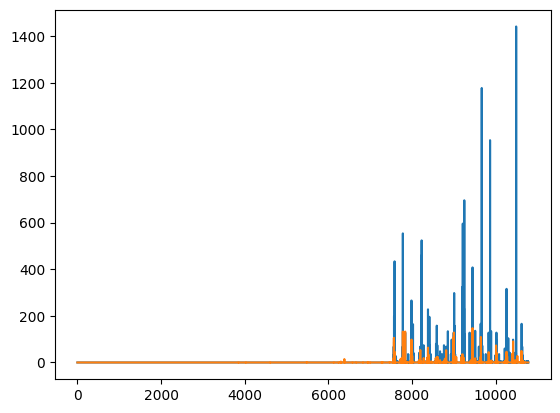

########################rmsle score 0.49164803217206365


In [25]:
def train(df_train, df_valid, label, params, features):
    '''
    训练函数
    '''
    train_label = df_train[label].values
    train_feat = df_train[features]

    valid_label = df_valid[label].values
    valid_feat = df_valid[features]
    gc.collect()

    trn_data = lgb.Dataset(train_feat, label=train_label)
    val_data = lgb.Dataset(valid_feat, label=valid_label)
    clf = lgb.train(params,
                    trn_data,
                    valid_sets=[trn_data, val_data],
                    verbose_eval=50,
                    early_stopping_rounds=100)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["importance_gain"] = clf.feature_importance(importance_type='gain')
    fold_importance_df = fold_importance_df.sort_values(by='importance', ascending=False)
    print(fold_importance_df[:30])
#     fold_importance_df.to_csv(f"importance_df.csv", index=None) 
    df_valid['{}_preds'.format(label)] = clf.predict(valid_feat, num_iteration=clf.best_iteration)
    # 负值修正
    df_valid['{}_preds'.format(label)] = df_valid['{}_preds'.format(label)].clip(lower=0.)
    
    result = mean_squared_log_error(np.expm1(df_valid[label]), 
                                    np.expm1(df_valid['{}_preds'.format(label)]))
    
#     plot(df_valid[label])
#     plot(df_valid['{}_preds'.format(label)])
#     show()
    plot(np.expm1(df_valid[label]))
    plot(np.expm1(df_valid['{}_preds'.format(label)]))
    show()
    
    return clf, result

clf_valid, result_valid = train(df_train, df_valid, 'pay_log', params, features)

print('########################rmsle score', np.sqrt(result_valid))

Training until validation scores don't improve for 100 rounds
[50]	training's rmse: 0.41967	valid_1's rmse: 0.41967
Did not meet early stopping. Best iteration is:
[55]	training's rmse: 0.41597	valid_1's rmse: 0.41597
                               Feature  importance  importance_gain
189                   pay_sum_day_day4          80      6457.226500
117                use_t2_day_sum_day3          60       363.201401
151                   pay_sum_day_day3          45      2892.056419
75                    pay_sum_day_day1          39       495.633538
179          mission_id_day_count_day4          36       255.487669
172          fb_used_time_day_sum_day4          30       673.994099
79                 use_t2_day_sum_day2          29       120.840318
113                   pay_sum_day_day2          24       307.101292
155                use_t2_day_sum_day4          23       130.165346
176              fb_result0_count_day4          20        72.130869
163           item_id_day_nunique_

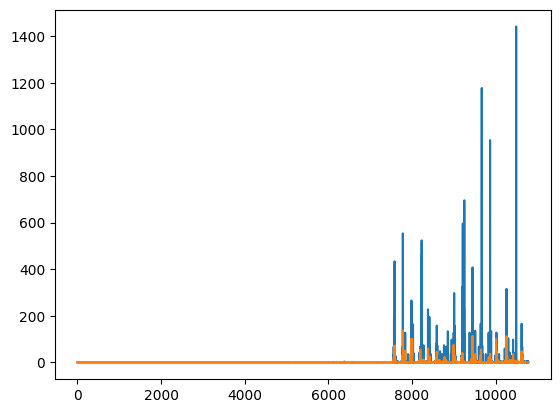

In [26]:
# 用 4,5,6,7,8 重新训练模型

params['num_iterations'] = clf_valid.best_iteration
clf_test, _ = train(df_valid, df_valid, 'pay_log', params, features)

In [27]:
df_test['pay'] = np.expm1(clf_test.predict(df_test[features]))
df_test['pay'] = df_test['pay'].clip(lower=0.)
df_test['pay'].describe()

count    10780.000000
mean         0.257847
std          2.553998
min          0.000000
25%          0.025833
50%          0.046152
75%          0.084055
max         97.482892
Name: pay, dtype: float64

In [28]:
sub = pd.read_csv('result/submission_sample.csv')
sub_df = df_test[['role_id', 'pay']].copy()
sub = sub[['role_id']].merge(sub_df, on='role_id', how='left')
sub[['role_id', 'pay']].to_csv('submission.csv', index=False)